Run with: sudo docker run --gpus all -it --rm -v $(pwd):/tf/notebooks -p 8888:8888 tensorflow/tensorflow:2.12.0-gpu-jupyter

In [1]:
# GB: Adding compatibility check
import cnn2snn
import akida as ak
import os

# Change Akida version
os.environ["CNN2SNN_TARGET_AKIDA_VERSION"] = "v1"

# Double-check Avida version
print(' Akida version: ', cnn2snn.get_akida_version())

# # And HW compatibility?
# myDevice = ak.devices()[0]
# print("Device: ", myDevice.desc)
# x = cnn2snn.check_model_compatibility(model=model_keras, device=myDevice)
# print("Non compatibilities: ", x)

 Akida version:  AkidaVersion.v1


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from glob import glob
from PIL import Image
import shutil
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import warnings

from IPython.display import clear_output

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model


seed = (4,2)

In [3]:
# os.chdir('notebooks/Documents/GitHub/GENG5551-Akida-Chip')
os.getcwd()

'c:\\Users\\Joo_Kai\\Documents\\GitHub\\GENG5551-Akida-Chip'

In [4]:
df = pd.read_csv('archive/HAM10000_metadata.csv')

size = (64, 64)

In [5]:
base_dir = './archive'
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(base_dir, '*', '*.jpg'))}

In [6]:
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize(size)))

In [7]:
df = df[['dx', 'image']]

In [8]:
df['dx'].value_counts()

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

In [9]:
df_nv = df[df['dx'] == 'nv']
df_df = df[df['dx'] == 'df']
vasc_df = df[df['dx'] == 'vasc']
akiec_df = df[df['dx'] == 'akiec']
bcc_df = df[df['dx'] == 'bcc']
bkl_df = df[df['dx'] == 'bkl']
mel_df = df[df['dx'] == 'mel']

# Data Augmentation

In [10]:
def aug_brightness(img_arr):
    aug_arr = tf.image.stateless_random_brightness(img_arr, 0.7, seed)
    aur_arr = np.array(aug_arr)

    return aug_arr

In [11]:
def aug_contrast(img_arr):
    aug_arr = tf.image.stateless_random_contrast(img_arr, 0.2, 0.8, seed)
    aur_arr = np.array(aug_arr)

    return aug_arr

In [12]:
def aug_flip_left_right(img_arr):
    aug_arr = tf.image.stateless_random_flip_left_right(img_arr, seed).numpy().tolist()
    aur_arr = np.array(aug_arr)

    return aug_arr

In [13]:
def aug_flip_up_down(img_arr):
    aug_arr = tf.image.stateless_random_flip_up_down(img_arr, seed).numpy().tolist()
    aur_arr = np.array(aug_arr)

    return aug_arr

In [14]:
def aug_hue(img_arr):
    aug_arr = tf.image.stateless_random_hue(img_arr, 0.5, seed)
    aur_arr = np.array(aug_arr)

    return aug_arr

In [15]:
def aug_saturation(img_arr):
    aug_arr = tf.image.stateless_random_saturation(img_arr, 0.1, 1, seed)
    aur_arr = np.array(aug_arr)

    return aug_arr

In [16]:
func_list = [aug_brightness, aug_contrast, aug_flip_left_right, aug_flip_up_down, aug_hue, aug_saturation]

In [17]:
def random_augmentation(images, dx, num_of_samples):
    new_images = []
    all_indices = []
    while (len(new_images) < num_of_samples):
        indices = np.random.randint(images.shape[0], size=6)
        r = list(map(lambda x, y: x(y), func_list, images.iloc[indices]))
        r = [np.array(tensor) for tensor in r]
        new_images.extend(r)
        all_indices.extend(indices)
        clear_output(wait=True)
        print(str(len(new_images)) + '/' + str(num_of_samples))

    new_images = pd.DataFrame({'dx': dx, 'image': new_images})

    return all_indices, new_images

In [18]:
df_images = df_df['image']
df_indices, df_new_images = random_augmentation(df_images, 'df', 700)

702/700


In [19]:
vasc_images = vasc_df['image']
vasc_indices, vasc_new_images = random_augmentation(vasc_images, 'vasc', 700)

702/700


In [20]:
akiec_images = akiec_df['image']
akiec_indices, akiec_new_images = random_augmentation(akiec_images, 'akiec', 1000)

1002/1000


In [21]:
bcc_images = bcc_df['image']
bcc_indices, bcc_new_images = random_augmentation(bcc_images, 'bcc', 1200)

1200/1200


In [22]:
bkl_images = bkl_df['image']
bkl_indices, bkl_new_images = random_augmentation(bkl_images, 'bkl', 1400)

1404/1400


In [23]:
mel_images = mel_df['image']
mel_indices, mel_new_images = random_augmentation(mel_images, 'mel', 1400)

1404/1400


In [24]:
new_images_df = pd.concat([df_new_images, vasc_new_images, akiec_new_images, bcc_new_images, bkl_new_images, mel_new_images], axis=0).reset_index(drop=True)
aug_df = pd.concat([df, new_images_df], axis=0).reset_index(drop=True)
aug_df = aug_df.sample(frac=1).reset_index(drop=True)

In [25]:
pd.DataFrame(aug_df['dx'].value_counts()).reset_index()

,dx,count
0,nv,6705
1,mel,2517
2,bkl,2503
3,bcc,1714
4,akiec,1329
5,vasc,844
6,df,817


In [26]:
labelEncoder = LabelEncoder()
aug_df['label'] = labelEncoder.fit_transform(aug_df['dx'])

In [27]:
x = np.asarray(aug_df['image'].to_list())
y = to_categorical(aug_df['label'], num_classes=7)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.20, random_state=42, shuffle=True)

In [28]:
y_train_labels = np.argmax(y_train, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Count the occurrences of each class in training and testing sets
train_counts = pd.Series(y_train_labels).value_counts().sort_index()
test_counts = pd.Series(y_test_labels).value_counts().sort_index()

# Display the counts
print("Training Set Class Distribution:")
print(train_counts)

print("\nTesting Set Class Distribution:")
print(test_counts)

Training Set Class Distribution:
0    1067
1    1368
2    2010
3     648
4    2040
5    5348
6     662
Name: count, dtype: int64

Testing Set Class Distribution:
0     262
1     346
2     493
3     169
4     477
5    1357
6     182
Name: count, dtype: int64


**SMOTE TECHNIQUE**

In [29]:
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

In [30]:
# Assuming x_train, y_train, x_test, y_test are already defined
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)


In [31]:
x_train_reshaped = x_train.reshape(x_train.shape[0], -1)


In [32]:
smote = SMOTE()
x_train_smote, y_train_smote = smote.fit_resample(x_train_reshaped, y_train.argmax(axis=1))


In [33]:
x_train_smote = x_train_smote.reshape(x_train_smote.shape[0], 64, 64, 3)
y_train_smote = tf.keras.utils.to_categorical(y_train_smote, num_classes=7)


In [34]:
os.environ["CNN2SNN_TARGET_AKIDA_VERSION"] = "v1"

In [35]:
import tensorflow as tf
from tensorflow.keras.models import load_model


model_path = 'initial_model83.h5'
model = load_model(model_path)


In [36]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)

print('Test Accuracy:', test_accuracy)
print('Test Loss:', test_loss)

103/103 [==============================] - 5s 43ms/step - loss: 0.2999 - accuracy: 0.9239
Test Accuracy: 0.923919677734375
Test Loss: 0.2998671531677246


33/33 [==============================] - 4s 101ms/step
Keras inference on 3286 images took 3.54 s.

Keras accuracy: 3036/3286.


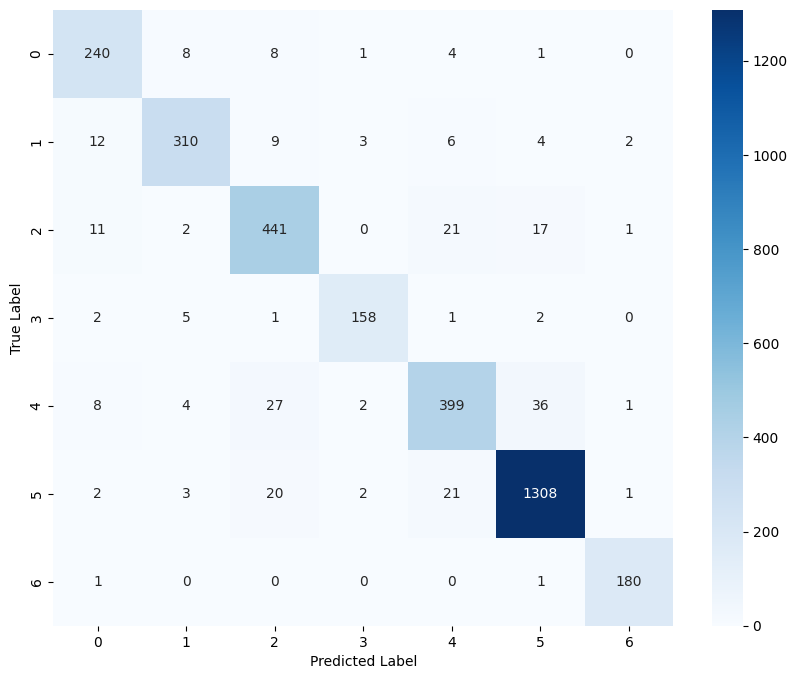

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

from timeit import default_timer as timer

# Get the number of images in the training dataset
num_images = len(x_test)

# Measure the time taken for Keras inference
start = timer()
potentials_keras = model.predict(x_test, batch_size=100)
end = timer()
print(f'Keras inference on {num_images} images took {end-start:.2f} s.\n')

# Get the predicted labels from the model output
preds_keras = np.argmax(potentials_keras, axis=1)

# Convert one-hot encoded y_train_smote back to class indices
y_train_smote_labels = np.argmax(y_test, axis=1)

# Calculate the accuracy
accuracy_keras = np.sum(np.equal(preds_keras, y_test_labels)) / num_images
print(f"Keras accuracy: {accuracy_keras*num_images:.0f}/{num_images}.")

# Generate the confusion matrix
cm = confusion_matrix(y_test_labels, preds_keras)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y_test_labels), 
            yticklabels=np.unique(y_test_labels))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [38]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import numpy as np

report = classification_report(y_test_labels, preds_keras, output_dict=True)

# Convert classification report into a pandas DataFrame
metrics_df = pd.DataFrame(report).transpose()

# Calculate accuracy for each class
accuracy_per_class = cm.diagonal() / cm.sum(axis=1)

# Only update accuracy for actual classes (avoid 'macro avg', 'weighted avg')
num_classes = len(accuracy_per_class)
class_labels = metrics_df.index[:num_classes]  # Use the first `num_classes` indices

# Assign accuracy to corresponding class rows
metrics_df.loc[class_labels, 'accuracy'] = accuracy_per_class

# Remove the rows that are not per-class metrics ('macro avg', 'weighted avg')
metrics_df = metrics_df.iloc[:num_classes]

# Display the table with precision, recall, and accuracy
metrics_df = metrics_df[['precision', 'recall', 'accuracy']]

from IPython.display import display
display(metrics_df)


,precision,recall,accuracy
0,0.869565,0.916031,0.916031
1,0.933735,0.895954,0.895954
2,0.871542,0.894523,0.894523
3,0.951807,0.934911,0.934911
4,0.882743,0.836478,0.836478
5,0.955442,0.963891,0.963891
6,0.972973,0.989011,0.989011


In [39]:
from akida_models import load_model

model_path = 'model_quantized.h5'
model = load_model(model_path)

In [40]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)

print('Test Accuracy:', test_accuracy)
print('Test Loss:', test_loss)

103/103 [==============================] - 7s 59ms/step - loss: 0.0000e+00 - accuracy: 0.8384
Test Accuracy: 0.8384053707122803
Test Loss: 0.0


33/33 [==============================] - 5s 130ms/step
Keras inference on 3286 images took 4.78 s.

Keras accuracy: 2755/3286.


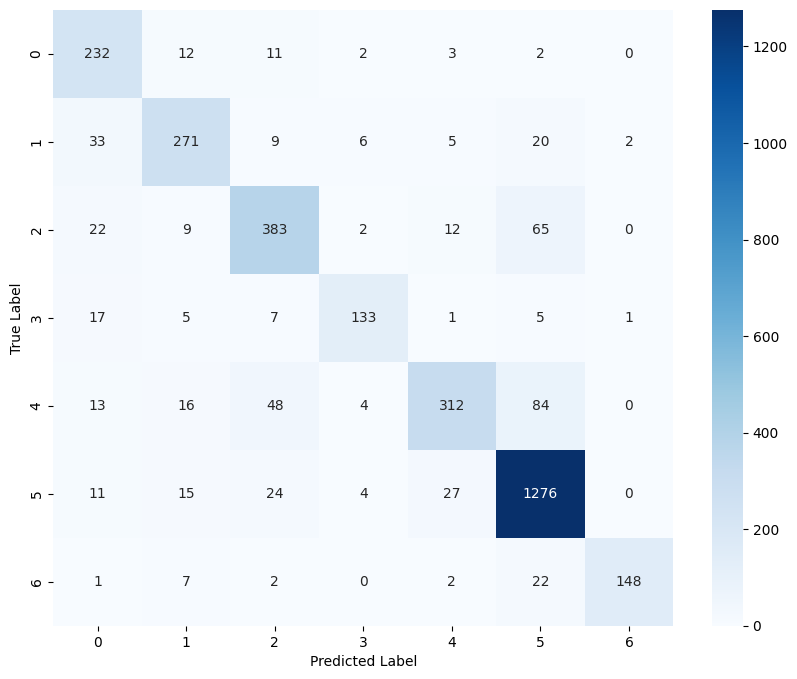

In [41]:
# Get the number of images in the training dataset
num_images = len(x_test)

# Measure the time taken for Keras inference
start = timer()
potentials_keras = model.predict(x_test, batch_size=100)
end = timer()
print(f'Keras inference on {num_images} images took {end-start:.2f} s.\n')

# Get the predicted labels from the model output
preds_keras = np.argmax(potentials_keras, axis=1)

# Convert one-hot encoded y_train_smote back to class indices
y_train_smote_labels = np.argmax(y_test, axis=1)

# Calculate the accuracy
accuracy_keras = np.sum(np.equal(preds_keras, y_test_labels)) / num_images
print(f"Keras accuracy: {accuracy_keras*num_images:.0f}/{num_images}.")

# Generate the confusion matrix
cm = confusion_matrix(y_test_labels, preds_keras)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y_test_labels), 
            yticklabels=np.unique(y_test_labels))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [42]:
report = classification_report(y_test_labels, preds_keras, output_dict=True)

# Convert classification report into a pandas DataFrame
metrics_df = pd.DataFrame(report).transpose()

# Calculate accuracy for each class
accuracy_per_class = cm.diagonal() / cm.sum(axis=1)

# Only update accuracy for actual classes (avoid 'macro avg', 'weighted avg')
num_classes = len(accuracy_per_class)
class_labels = metrics_df.index[:num_classes]  # Use the first `num_classes` indices

# Assign accuracy to corresponding class rows
metrics_df.loc[class_labels, 'accuracy'] = accuracy_per_class

# Remove the rows that are not per-class metrics ('macro avg', 'weighted avg')
metrics_df = metrics_df.iloc[:num_classes]

# Display the table with precision, recall, and accuracy
metrics_df = metrics_df[['precision', 'recall', 'accuracy']]

from IPython.display import display
display(metrics_df)

,precision,recall,accuracy
0,0.705167,0.885496,0.885496
1,0.808955,0.783237,0.783237
2,0.791322,0.776876,0.776876
3,0.880795,0.786982,0.786982
4,0.861878,0.654088,0.654088
5,0.865672,0.940310,0.940310
6,0.980132,0.813187,0.813187


In [43]:
from akida_models import load_model

model_path = 'models/best_models/model_quantized.h5'
model = load_model(model_path)

In [44]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)

print('Test Accuracy:', test_accuracy)
print('Test Loss:', test_loss)

103/103 [==============================] - 9s 48ms/step - loss: 0.0000e+00 - accuracy: 0.8220
Test Accuracy: 0.8219720125198364
Test Loss: 0.0


33/33 [==============================] - 8s 113ms/step
Keras inference on 3286 images took 7.89 s.

Keras accuracy: 2701/3286.


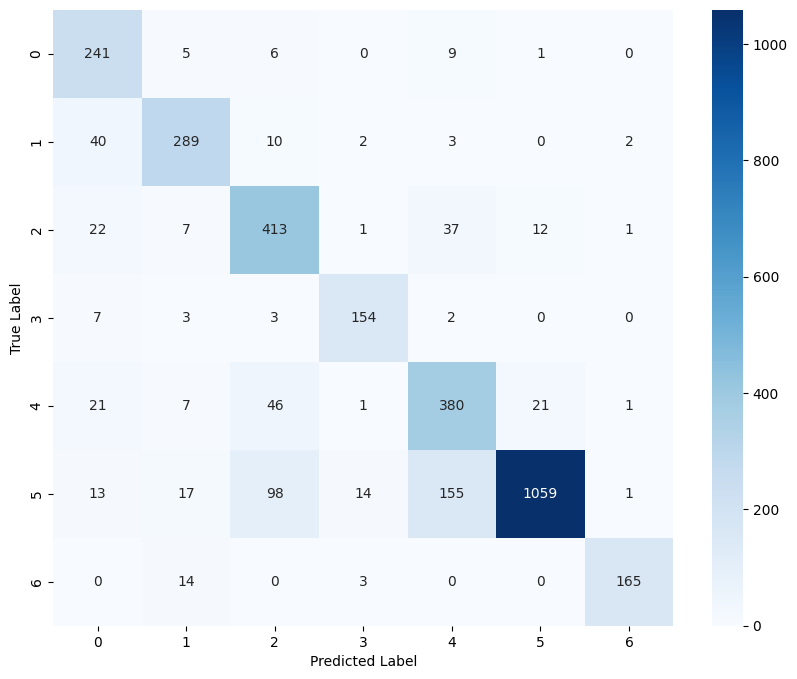

In [45]:
# Get the number of images in the training dataset
num_images = len(x_test)

# Measure the time taken for Keras inference
start = timer()
potentials_keras = model.predict(x_test, batch_size=100)
end = timer()
print(f'Keras inference on {num_images} images took {end-start:.2f} s.\n')

# Get the predicted labels from the model output
preds_keras = np.argmax(potentials_keras, axis=1)

# Convert one-hot encoded y_train_smote back to class indices
y_train_smote_labels = np.argmax(y_test, axis=1)

# Calculate the accuracy
accuracy_keras = np.sum(np.equal(preds_keras, y_test_labels)) / num_images
print(f"Keras accuracy: {accuracy_keras*num_images:.0f}/{num_images}.")

# Generate the confusion matrix
cm = confusion_matrix(y_test_labels, preds_keras)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y_test_labels), 
            yticklabels=np.unique(y_test_labels))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [46]:
report = classification_report(y_test_labels, preds_keras, output_dict=True)

# Convert classification report into a pandas DataFrame
metrics_df = pd.DataFrame(report).transpose()

# Calculate accuracy for each class
accuracy_per_class = cm.diagonal() / cm.sum(axis=1)

# Only update accuracy for actual classes (avoid 'macro avg', 'weighted avg')
num_classes = len(accuracy_per_class)
class_labels = metrics_df.index[:num_classes]  # Use the first `num_classes` indices

# Assign accuracy to corresponding class rows
metrics_df.loc[class_labels, 'accuracy'] = accuracy_per_class

# Remove the rows that are not per-class metrics ('macro avg', 'weighted avg')
metrics_df = metrics_df.iloc[:num_classes]

# Display the table with precision, recall, and accuracy
metrics_df = metrics_df[['precision', 'recall', 'accuracy']]

from IPython.display import display
display(metrics_df)

,precision,recall,accuracy
0,0.700581,0.919847,0.919847
1,0.845029,0.835260,0.835260
2,0.717014,0.837728,0.837728
3,0.880000,0.911243,0.911243
4,0.648464,0.796646,0.796646
5,0.968893,0.780398,0.780398
6,0.970588,0.906593,0.906593
